In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras
import jieba
import os
import numpy as np
import re

print(tf.__version__)

2.0.0


In [2]:
pos_path = '../data/pos/'
neg_path = '../data/neg/'
pos_list = os.listdir(pos_path)
neg_list = os.listdir(neg_path)

In [3]:
# 停用词词典
stop_words = []
# 读取停用词函数
with open("../data/stop_words_line.txt", encoding="utf-8") as st:
    stop_words = st.readline().split(" ")

def delete_stop_words(words):
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def str_strim(line):
    new_line = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", line)
    return new_line.strip().strip().replace(" ", "").replace("\r", "").replace("\n", "")

def segment(line):
    return delete_stop_words(jieba.cut(str_strim(line)))

In [4]:
# 词语索引
index = 1
# 所有词的索引词典
words_dict = {}

origin_data = []
train_label = []
for doc in pos_list:
    with open(pos_path + doc, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            words = segment(line)
            origin_data.append(words)
            train_label.append(1)
            for word in words:
                if word not in words_dict:
                    words_dict[word] = index
                    index += 1
            
for doc in neg_list:
    with open(neg_path + doc, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            words = segment(line)
            origin_data.append(words)
            train_label.append(0)
            for word in words:
                if word not in words_dict:
                    words_dict[word] = index
                    index += 1

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.687 seconds.
Prefix dict has been built succesfully.


In [5]:
index, words_dict.popitem()

(1754, ('Choice', 67))

In [6]:
len(origin_data), len(train_label)

(487, 487)

In [33]:
# 讲原始数据中文转化为索引
# 将数组转换为表示单词出现与否的由 0 和 1 组成的向量，类似于 one-hot 编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。然后，将其作为网络的首层——一个可以处理浮点型向量数据的稠密层。不过，这种方法需要大量的内存，需要一个大小为 num_words * num_reviews 的矩阵。
# 或者，我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 max_length * num_reviews 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层。
train_data = []
for words in origin_data:
    vector = []
    for word in words:
        if word not in words_dict:
            continue
        vector.append(int(words_dict.get(word)))
#     train_data.append(np.array(vector))
    train_data.append(vector)

# train_data = np.array(train_data)
# train_label = np.array(train_label)

In [34]:
len(train_data), type(train_data), type(train_data[0]), type(train_data[0][0])

(487, list, list, int)

In [35]:
print(train_data[0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [46]:
# train_data = keras.preprocessing.sequence.pad_sequences([[1,2],[4,6,7,8]],padding='post',maxlen=1024)
train_data = keras.preprocessing.sequence.pad_sequences(train_data,padding='post',maxlen=2048)

In [47]:
print(train_data[1])

[10  0  0 ...  0  0  0]


In [56]:
# 层按顺序堆叠以构建分类器：
# 第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。
# 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
# 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。
# 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 2048

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          32768     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 33,057
Trainable params: 33,057
Non-trainable params: 0
_________________________________________________________________


In [58]:
# 一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），
# 我们将使用 binary_crossentropy 损失函数。这不是损失函数的唯一选择，例如，您可以选择 mean_squared_error 。
# 但是，一般来说 binary_crossentropy 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，
# 指的是度量 ground-truth 分布与预测值之间的“距离”。

# 现在，配置模型来使用优化器和损失函数：
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
# 创建一个验证集
train_size = 20
x_val = train_data[:train_size]
partial_x_train = train_data[train_size:]

y_val = train_label[:train_size]
partial_y_train = train_label[train_size:]

In [60]:
train_data = train_data.astype(np.int64)

In [61]:
type(partial_x_train), type(partial_x_train[0]), type(partial_x_train[0][0]),type(partial_y_train),type(partial_y_train[0])

(numpy.ndarray, numpy.ndarray, numpy.int64, numpy.ndarray, numpy.int64)

In [62]:
len(train_data), len(train_label),len(partial_x_train),len(partial_y_train),len(x_val),len(y_val)

(487, 487, 467, 467, 20, 20)

In [63]:
# 训练模型¶
# 以 512 个样本的 mini-batch 大小迭代 40 个 epoch 来训练模型。这是指对 x_train 和 y_train 张量中所有样本的的 40 次迭代。
# 在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 467 samples, validate on 20 samples
Epoch 1/40
467/467 [==============================] - 1s 1ms/sample - loss: 0.6924 - accuracy: 0.5632 - val_loss: 0.7031 - val_accuracy: 0.0000e+00
Epoch 2/40
467/467 [==============================] - 0s 192us/sample - loss: 0.6919 - accuracy: 0.5632 - val_loss: 0.7066 - val_accuracy: 0.0000e+00
Epoch 3/40
467/467 [==============================] - 0s 194us/sample - loss: 0.6915 - accuracy: 0.5632 - val_loss: 0.7101 - val_accuracy: 0.0000e+00
Epoch 4/40
467/467 [==============================] - 0s 218us/sample - loss: 0.6911 - accuracy: 0.5632 - val_loss: 0.7137 - val_accuracy: 0.0000e+00
Epoch 5/40
467/467 [==============================] - 0s 219us/sample - loss: 0.6908 - accuracy: 0.5632 - val_loss: 0.7172 - val_accuracy: 0.0000e+00
Epoch 6/40
467/467 [==============================] - 0s 188us/sample - loss: 0.6904 - accuracy: 0.5632 - val_loss: 0.7208 - val_accuracy: 0.0000e+00
Epoch 7/40
467/467 [==============================] - 0s 

## 评估模型

我们来看一下模型的性能如何。将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [66]:
# results = model.evaluate(test_data,  test_labels, verbose=2)
# print(results)
results = model.evaluate(train_data,  train_label, verbose=2)
print(results)

487/1 - 0s - loss: 0.6328 - accuracy: 0.5400
[0.6907112446653769, 0.5400411]


In [67]:
# model.fit() 返回一个 History 对象，该对象包含一个字典，其中包含训练阶段所发生的一切事件
# 有四个条目：在训练和验证期间，每个条目对应一个监控指标。我们可以使用这些条目来绘制训练与验证过程的损失值（loss）和准确率（accuracy），以便进行比较。
history_dict = history.history
history_dict.keys()

dict_keys(['val_accuracy', 'loss', 'val_loss', 'accuracy'])

In [68]:
# 创建一个准确率（accuracy）和损失值（loss）随时间变化的图表
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

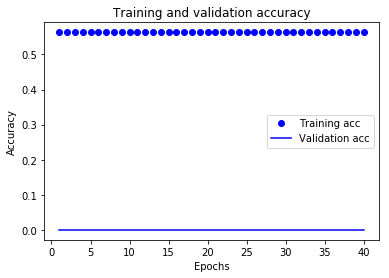

In [69]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


在该图中，点代表训练损失值（loss）与准确率（accuracy），实线代表验证损失值（loss）与准确率（accuracy）。

注意训练损失值随每一个 epoch *下降*而训练准确率（accuracy）随每一个 epoch *上升*。这在使用梯度下降优化时是可预期的——理应在每次迭代中最小化期望值。

验证过程的损失值（loss）与准确率（accuracy）的情况却并非如此——它们似乎在 20 个 epoch 后达到峰值。这是过拟合的一个实例：模型在训练数据上的表现比在以前从未见过的数据上的表现要更好。在此之后，模型过度优化并学习*特定*于训练数据的表示，而不能够*泛化*到测试数据。

对于这种特殊情况，我们可以通过在 20 个左右的 epoch 后停止训练来避免过拟合。稍后，您将看到如何通过回调自动执行此操作。